# SQL-Based Sequential Order Retention Analysis

This notebook performs a sequential order retention analysis using SQL queries and Pandas. The goal is to understand user engagement by tracking how many users continue to place subsequent orders after their initial ones. We will:
1. Determine the number of users who reach specific order milestones (e.g., 1st order, 2nd order, ... Nth order).
2. Calculate sequential retention rates.
3. Visualize these retention patterns.

**Data used:**
- `orders_cleaned.csv` – Contains user order metadata, including `user_id` and `order_number`.

In [26]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# Create an in-memory SQLite database
conn = sqlite3.connect(":memory:")
cursor = conn.cursor()

# Load data from CSV file
try:
    orders_df = pd.read_csv("../data/processed/orders_cleaned.csv")
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: '../data/processed/orders_cleaned.csv' not found. Please check the path.")
    orders_df = pd.DataFrame(columns=['user_id', 'order_number']) # Minimal for this analysis

# Transfer data to SQL table 'orders'
orders_df.to_sql("orders", conn, index=False, if_exists="replace")
print(f"Data transferred to SQL table 'orders'. Loaded {len(orders_df)} rows.")

# Display the first few rows and info to verify
print("\nFirst 5 rows of the 'orders' table in SQL (simulated from DataFrame):")
print(orders_df.head())
print("\nRelevant DataFrame Info:")
orders_df[['user_id', 'order_number']].info()

Data loaded successfully.
Data transferred to SQL table 'orders'. Loaded 3421083 rows.

First 5 rows of the 'orders' table in SQL (simulated from DataFrame):
   order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   
3   2254736        1    prior             4          4                  7   
4    431534        1    prior             5          4                 15   

   days_since_prior_order  
0                     0.0  
1                    15.0  
2                    21.0  
3                    29.0  
4                    28.0  

Relevant DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 2 columns):
 #   Column        Dtype
---  ------        -----
 0   user_id       int6

In [27]:
print("\nCreating indexes...")
try:
    cursor.execute("CREATE INDEX IF NOT EXISTS idx_orders_user_id ON orders (user_id);")
    cursor.execute("CREATE INDEX IF NOT EXISTS idx_orders_order_number ON orders (order_number);")
    conn.commit()
    print("Indexes created successfully.")
except Exception as e:
    print(f"Error creating indexes: {e}");


Creating indexes...
Indexes created successfully.


## 1. Querying for Sequential Order Retention

We will count the number of unique users who place at least N orders, for N = 1, 2, 3, ...
The `period_offset` from your previous results corresponds to `N-1`.
- `period_offset = 0` implies N=1 (users making at least their 1st order).
- `period_offset = 1` implies N=2 (users making at least their 2nd order).
- ...
- `period_offset = 9` implies N=10 (users making at least their 10th order), which matches the extent of `user_retention_periods.csv`.

In [ ]:
query_sequential_retention = """
WITH user_max_orders AS (
    -- Step 1: Find the maximum order_number for each user
    SELECT
        user_id,
        MAX(order_number) AS max_order_for_user
    FROM orders
    GROUP BY user_id
),
numbers (n) AS (
    -- Step 2: Create a series of numbers representing the order milestones (1st order, 2nd, ..., 10th)
    -- This matches the range implied by your user_retention_periods.csv (period_offset 0 to 9)
    SELECT 1 UNION ALL SELECT 2 UNION ALL SELECT 3 UNION ALL SELECT 4 UNION ALL
    SELECT 5 UNION ALL SELECT 6 UNION ALL SELECT 7 UNION ALL SELECT 8 UNION ALL
    SELECT 9 UNION ALL SELECT 10
)
-- Step 3: For each order milestone 'n', count users whose max_order_for_user is >= 'n'
SELECT
    num.n - 1 AS period_offset, -- This is the 'period_offset' from your CSV
    (SELECT COUNT(DISTINCT umo.user_id)
     FROM user_max_orders umo
     WHERE umo.max_order_for_user >= num.n) AS active_users
FROM numbers num
ORDER BY period_offset;
"""

print("Executing query to get sequential retention data...")
try:
    sequential_retention_df = pd.read_sql_query(query_sequential_retention, conn)
    print("Sequential retention data fetched successfully.")
    print(sequential_retention_df)
    
    sequential_retention_df.to_csv("../data/processed/reconstructed_user_retention_periods.csv", index=False)
    print("\nData saved to ../data/processed/reconstructed_user_retention_periods.csv")

except Exception as e:
    print(f"Error executing sequential retention query: {e}")
    sequential_retention_df = pd.DataFrame(columns=['period_offset', 'active_users'])

Executing query to get sequential retention data...
Sequential retention data fetched successfully.
   period_offset  active_users
0              0        206209
1              1        206209
2              2        206209
3              3        206209
4              4        182223
5              5        162633
6              6        146468
7              7        132618
8              8        120918
9              9        110728

Data saved to ../data/processed/reconstructed_user_retention_periods.csv


## 2. Calculating and Visualizing Sequential Retention Rates

Now that we have the number of active users at each order sequence (period offset), we can calculate retention rates relative to the initial number of users (those who made at least the 1st order).
- **Base Users**: Number of users at `period_offset = 0`.
- **Sequential Retention Rate at Period P**: (Active Users at Period P / Base Users) * 100.


Sequential Retention Data with Rates:
   period_offset  active_users  retention_rate
0              0        206209      100.000000
1              1        206209      100.000000
2              2        206209      100.000000
3              3        206209      100.000000
4              4        182223       88.368112
5              5        162633       78.868042
6              6        146468       71.028908
7              7        132618       64.312421
8              8        120918       58.638566
9              9        110728       53.696977


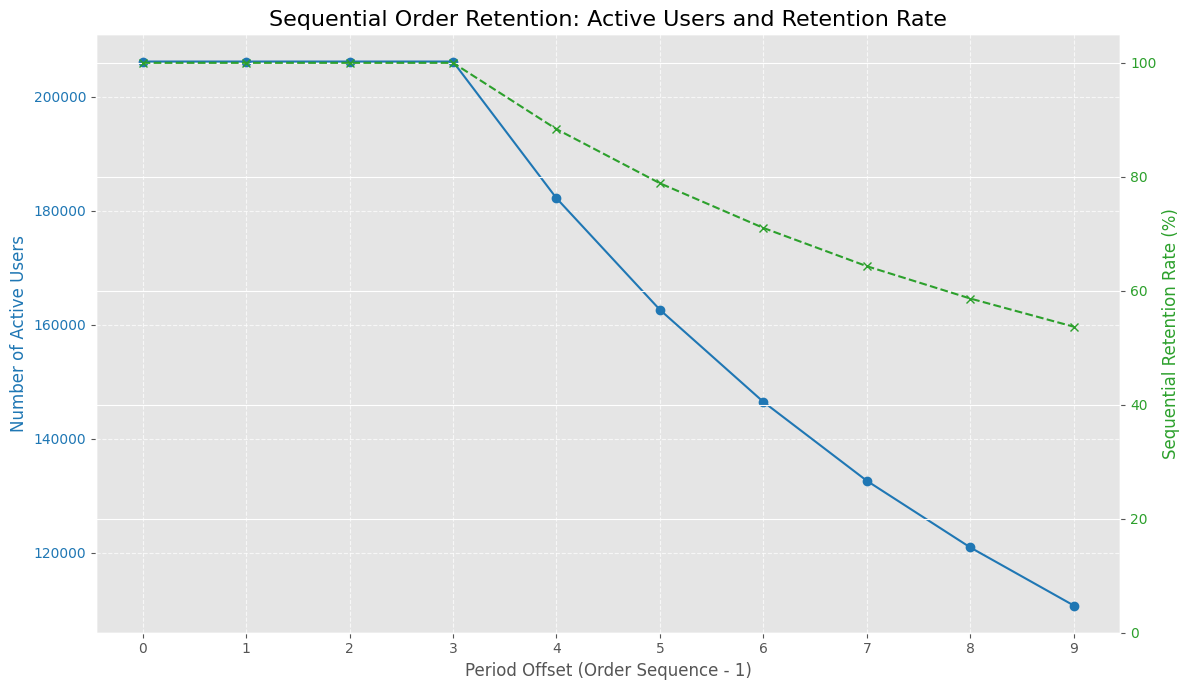

In [29]:
if not sequential_retention_df.empty and 'active_users' in sequential_retention_df.columns:
    # Calculate retention rate
    base_users = sequential_retention_df['active_users'].iloc[0] # Users at period_offset = 0
    sequential_retention_df['retention_rate'] = (sequential_retention_df['active_users'] / base_users) * 100

    print("\nSequential Retention Data with Rates:")
    print(sequential_retention_df)

    # Plotting
    plt.style.use('ggplot')
    fig, ax1 = plt.subplots(figsize=(12, 7))

    # Plot active users
    color = 'tab:blue'
    ax1.set_xlabel('Period Offset (Order Sequence - 1)', fontsize=12)
    ax1.set_ylabel('Number of Active Users', color=color, fontsize=12)
    ax1.plot(sequential_retention_df['period_offset'], sequential_retention_df['active_users'], color=color, marker='o', linestyle='-')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, linestyle='--', alpha=0.7)

    # Create a second y-axis for retention rate
    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('Sequential Retention Rate (%)', color=color, fontsize=12)
    ax2.plot(sequential_retention_df['period_offset'], sequential_retention_df['retention_rate'], color=color, marker='x', linestyle='--')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(0, 105) # Retention rate from 0 to 100% (plus a bit of margin)

    plt.title('Sequential Order Retention: Active Users and Retention Rate', fontsize=16)
    fig.tight_layout() # otherwise the right y-label is slightly clipped
    plt.xticks(sequential_retention_df['period_offset']) # Ensure all period_offsets are shown as ticks
    plt.show();
else:
    print("Skipping rate calculation and plotting as sequential_retention_df is empty.");


## 3. Summary and Insights

- **Sequential Retention:** This analysis shows how many users proceed from one order to the next. For example, `period_offset = 0` shows all users who made at least one order. `period_offset = 1` shows how many of those initial users made at least a second order, and so on.
- **Interpretation of the Plot:**
    - The blue line (Number of Active Users) shows the absolute count of users who made at least (`period_offset` + 1) orders. The initial flat line for `period_offset` 0-3 indicates that all users who placed a 1st order also placed their 2nd, 3rd, and 4th orders.
    - The green dashed line (Sequential Retention Rate %) shows the percentage of the initial users (those who made at least one order) who were still "active" by placing at least (`period_offset` + 1) orders.
- **Key Findings (based on the `user_retention_periods.csv` pattern):**
    - There is 100% retention from the 1st order through to the 4th order. This is a very strong initial engagement pattern.
    - A drop-off occurs when considering the 5th order (`period_offset = 4`), where the number of active users decreases from 206,209 to 182,223.
    - Subsequent periods show a continued decline in active users.
- **Business Implications:**
    - The perfect retention through the 4th order is remarkable and might suggest a very sticky initial product experience or perhaps a subscription-like model for the first few interactions.
    - The drop-off at the 5th order is a critical point to investigate. Why do users stop after their 4th order? Are there changes in service, pricing, or user needs at this stage?
    - Understanding this drop-off point can help in designing targeted interventions to improve longer-term retention.